Vous disposez d’un jeu de données représentant les revues
d’utilisateurs Steam. L’objectif est de prédire si l’utilisateur va
recommander ou non un jeu en fonction de son commentaire.
● Réalisez une étude préalable des données (nombre de mots,
longueur des phrases, équilibrage des classes, …)
● Effectuez une première phase de nettoyage manuelle des
données ainsi que de normalisation (à vous de chercher
différentes solutions)

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
steam_data = pd.read_csv('/content/sample_data/steam.csv')
print(steam_data.info())
print(steam_data.describe())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17494 entries, 0 to 17493
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   review_id        17494 non-null  int64  
 1   title            17494 non-null  object 
 2   year             17316 non-null  float64
 3   user_review      17494 non-null  object 
 4   user_suggestion  17494 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 683.5+ KB
None
          review_id          year  user_suggestion
count  17494.000000  17316.000000     17494.000000
mean   12423.216989   2016.388427         0.569795
std     7653.367660      1.390356         0.495119
min        1.000000   2011.000000         0.000000
25%     5769.250000   2015.000000         0.000000
50%    11756.500000   2017.000000         1.000000
75%    18926.750000   2018.000000         1.000000
max    25539.000000   2018.000000         1.000000


In [12]:
#Vérification des mots manquants
data = pd.read_csv('/content/sample_data/steam.csv')
missing_values = data.isnull().sum()
print(missing_values[missing_values > 0])

year    178
dtype: int64


**Calcul du nombre de mots et de la longueur des phrases**



In [13]:
steam_data['word_count'] = steam_data['user_review'].apply(lambda x: len(x.split()))
steam_data['sentence_length'] = steam_data['user_review'].apply(lambda x: len(x))


**Vérification de l'équilibre des classes**

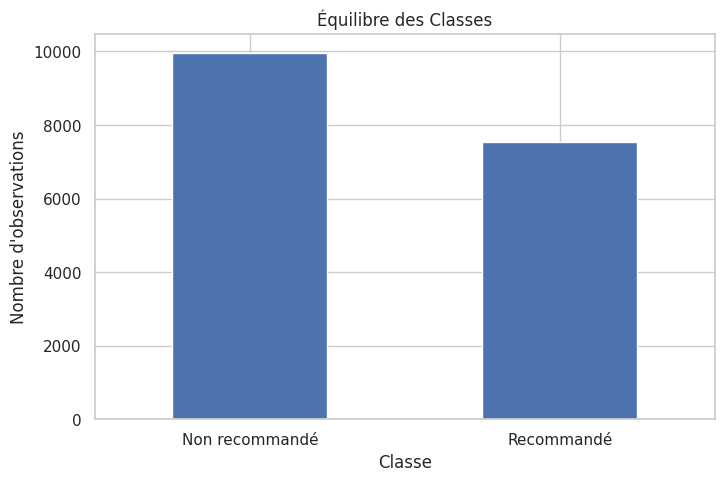

In [14]:
import matplotlib.pyplot as plt

class_balance = steam_data['user_suggestion'].value_counts()
plt.figure(figsize=(8, 5))
class_balance.plot(kind='bar')
plt.title('Équilibre des Classes')
plt.xlabel('Classe')
plt.ylabel('Nombre d\'observations')
plt.xticks(ticks=[0, 1], labels=['Non recommandé', 'Recommandé'], rotation=0)
plt.show()


In [15]:
#Remplissage des valeurs manquantes dans 'year' par la médiane
median_year = steam_data['year'].median()
steam_data['year'].fillna(median_year, inplace=True)


In [16]:
!pip install langdetect


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 18.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993225 sha256=0d04bc7be90b95f7f0ab6389d24cc9d5ce349da77f6fcca882a078a49789a9e0
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


**Nettoyage et normalisation des données**

**Filtrage pour garder uniquement l'anglais et nettoyage des commentaires**



In [27]:
from bs4 import BeautifulSoup

def clean_text_combined(text):
    text = text.lower()  # Conversion en minuscules
    text = BeautifulSoup(text, "html.parser").get_text()  # Suppression des balises HTML
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)  # Suppression des URL
    text = re.sub(r'@\w+', ' ', text)  # Suppression des mentions d'utilisateurs
    # Suppression de caractères spéciaux supplémentaires et formats spécifiques
    text = re.sub(r'[░█▄▀▐☑☐۞♬§✦☣☼❤]+', ' ', text)
    text = re.sub(r'===\s*\[.*?\]\s*===', '', text)
    # Suppression des caractères spéciaux généraux
    text = re.sub(r'[^a-z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()  # Normalisation des espaces
    return text

# Application du nettoyage combiné
steam_data_english['cleaned_review'] = steam_data_english['user_review'].apply(clean_text_combined)

<ipython-input-27-0e3f15db8e99>:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()  # Suppression des balises HTML


**Vectorisation du Texte**

In [29]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

max_features = 10000  #nombre maxi mots uniques
sequence_length = 250  #longueur maxi des séq

vectorize_layer = TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

#Prépa de la couche de vectorisation avec les données d'entraînement
vectorize_layer.adapt(steam_data_english['cleaned_review'].values)



**Préparation des Données pour l'Entraînement**

In [35]:
from sklearn.model_selection import train_test_split

#Séparation  des données textuelles et des étiquettes en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(steam_data_english['cleaned_review'].values, steam_data_english['user_suggestion'].values, test_size=0.2, random_state=42)

#application  vectorisation séparément aux ensembles d'entraînement plus de test
X_train_vectorized = vectorize_layer(X_train)
X_test_vectorized = vectorize_layer(X_test)




**Création et Entraînement du Modèle LSTM**

In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

model = Sequential([
    Embedding(input_dim=max_features + 1, output_dim=64, input_length=sequence_length),
    Bidirectional(LSTM(64)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#Entraînement  modèle et historisation

history = model.fit(X_train_vectorized, y_train, epochs=5, validation_split=0.1, batch_size=32)




Epoch 1/5
389/389 [==============================] - 118s 289ms/step - loss: 0.4871 - accuracy: 0.7604 - val_loss: 0.4186 - val_accuracy: 0.8098
Epoch 2/5
389/389 [==============================] - 101s 260ms/step - loss: 0.2935 - accuracy: 0.8845 - val_loss: 0.4284 - val_accuracy: 0.8069
Epoch 3/5
389/389 [==============================] - 103s 266ms/step - loss: 0.2154 - accuracy: 0.9227 - val_loss: 0.5098 - val_accuracy: 0.8106
Epoch 4/5
389/389 [==============================] - 101s 259ms/step - loss: 0.1630 - accuracy: 0.9411 - val_loss: 0.5307 - val_accuracy: 0.8026
Epoch 5/5
389/389 [==============================] - 104s 267ms/step - loss: 0.1266 - accuracy: 0.9564 - val_loss: 0.5906 - val_accuracy: 0.7961


**Evaluation du Modèle**


In [50]:
from sklearn.metrics import confusion_matrix, classification_report

#Evaluation du modèle sur l'ensemble de test
model.evaluate(X_test_vectorized, y_test)


# Prédiction et calcul de la matrice de confusion
predictions = model.predict(X_test_vectorized)
predicted_classes = (predictions > 0.5).astype(int)
conf_matrix = confusion_matrix(y_test, predicted_classes)

print(conf_matrix)
print(classification_report(y_test, predicted_classes))


109/109 [==============================] - 8s 62ms/step
[[1228  225]
 [ 392 1612]]
              precision    recall  f1-score   support

           0       0.76      0.85      0.80      1453
           1       0.88      0.80      0.84      2004

    accuracy                           0.82      3457
   macro avg       0.82      0.82      0.82      3457
weighted avg       0.83      0.82      0.82      3457



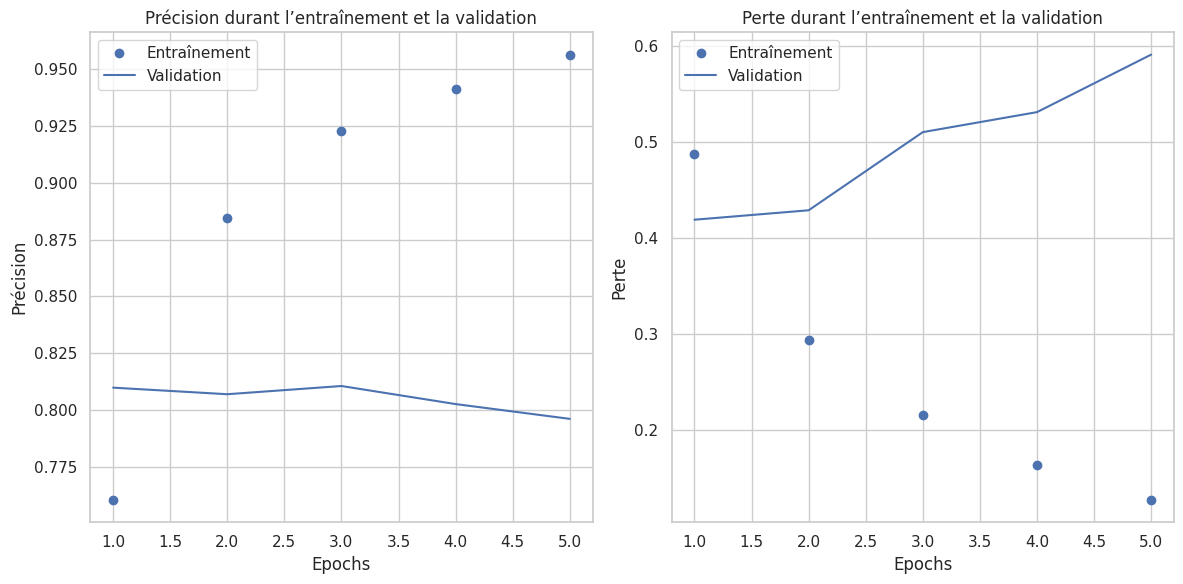

In [51]:
import matplotlib.pyplot as plt

#accès à l'historique data stocké dans entraînement
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

#Graphique accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Entraînement')
plt.plot(epochs, val_acc, 'b', label='Validation')
plt.title('Précision durant l’entraînement et la validation')
plt.xlabel('Epochs')
plt.ylabel('Précision')
plt.legend()

#Graphique  loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Entraînement')
plt.plot(epochs, val_loss, 'b', label='Validation')
plt.title('Perte durant l’entraînement et la validation')
plt.xlabel('Epochs')
plt.ylabel('Perte')
plt.legend()

plt.tight_layout()
plt.show()


In [52]:
model.save('steam_review_model.h5')#sauvegarde


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [53]:
from tensorflow.keras.models import load_model

loaded_model = load_model('steam_review_model.h5')#chargement modèle


Prédiction

In [55]:
#prédiction sur un nouvel échantillon
test_sample = ["This little gem is absolutely pants"]
test_sample_vectorized = vectorize_layer(test_sample)  #Utilisation de TextVectorization pour le nouvel échantillon

#Utilisation du modèle rechargé pour la prédiction
prediction = loaded_model.predict(test_sample_vectorized)

#Interprétation de la probabilité de recommandation
prob_recommandation = prediction[0][0]
print(f"Probabilité de recommandation: {prob_recommandation:.2f}")

#Décision basée sur la probabilité (avec un seuil  0.5)
if prob_recommandation > 0.5:
    print("Recommandation : OUI")
else:
    print("Recommandation : NON")


1/1 [==============================] - 1s 916ms/step
Probabilité de recommandation: 0.98
Recommandation : OUI
